# 0. Instalación de librerias

Se utiliza numpy, scipy, matplotlib y mpmath. La siguiente celda corresponde a su instalación.

In [28]:
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install mpmath


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Programar Solución Analítica

In [1]:
import numpy as np
from scipy.special import spherical_jn, eval_legendre, spherical_yn
import matplotlib.pyplot as plt

In [18]:
# Encontré esta issue con la implementación de la función de Hankel esférica
# https://github.com/scipy/scipy/issues/7722


def spherical_hn1(n, z, derivative=False):
    """
    Evalua función esferica de Hankel de primer tipo de grado n en z
    """
    return spherical_jn(n, z, derivative) + 1j * spherical_yn(n, z, derivative)

In [19]:
def green_expandido(D, d, N, k=1):
    """
    Evalua la expansión de la función de Green en serie de funciones especiales.
    D: distancia larga
    d: distancia corta
    N: número de términos de la serie
    k: número de onda
    """
    sum = 0
    d_norm = np.linalg.norm(d)
    D_norm = np.linalg.norm(D)

    for l in range(N):
        sum += (
            (-1) ** l
            * (2 * l + 1)
            * spherical_jn(l, k * d_norm)
            * spherical_hn1(l, k * D_norm)
            * eval_legendre(l, np.dot(d, D) / (d_norm * D_norm))
        )

    return 1j * k * sum

In [20]:
def test_green_expandido(D, d, N, k):
    """
    Prueba la función green_expandido
    """
    real = np.exp(1j * k * np.linalg.norm(D + d)) / np.linalg.norm(D + d)
    aproximaciones = []
    errores = []
    for i in range(N):
        aprox = green_expandido(D, d, i, k)
        aproximaciones.append(aprox)

        errores.append(np.abs(real - aprox))

    plt.plot(range(N), np.real(aproximaciones), label="Aproximación Parte Real")
    plt.plot(range(N), np.imag(aproximaciones), label="Aproximación Parte Imaginaria")
    plt.legend()
    plt.show()

    plt.plot(range(N), errores, label="Error")
    plt.yscale("log")
    plt.legend()
    plt.show()

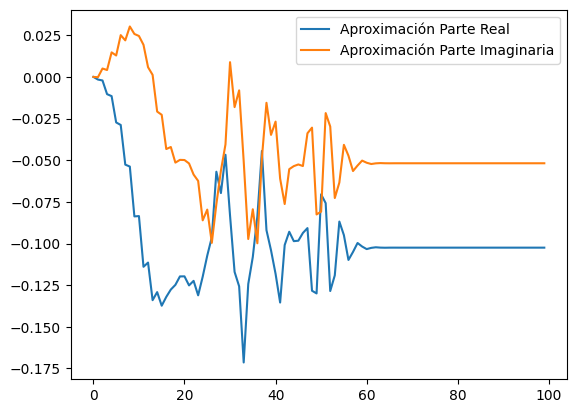

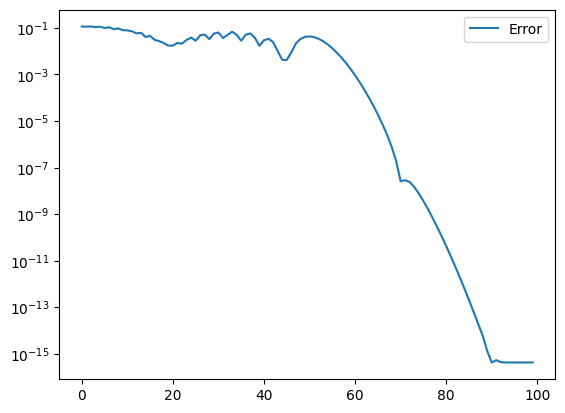

In [21]:
d = np.array([0.5, 0, 0.1])
D = np.array([8, 1, 1.5])
N = 100

test_green_expandido(D, d, N, 100)

## 2. Encontrar Frecuencia en la que falla

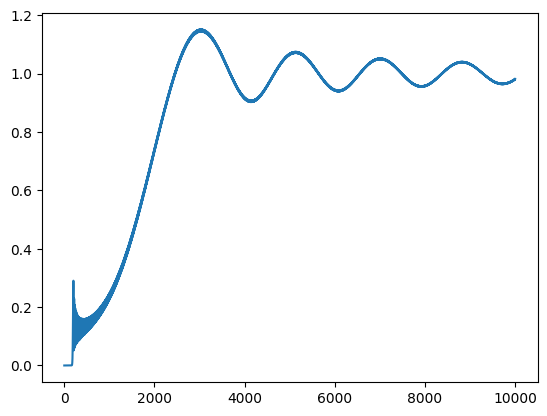

In [22]:
errores2 = []
frecuencia_max = 10000
for k in range(1, frecuencia_max):
    real = np.exp(1j * k * np.linalg.norm(D + d)) / np.linalg.norm(D + d)
    aprox = green_expandido(D, d, 100, k)

    errores2.append(np.abs(real - aprox) / np.abs(real))

plt.plot(range(1, frecuencia_max), errores, label="Error")

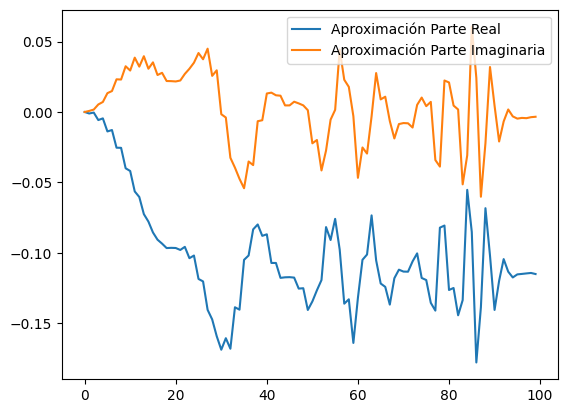

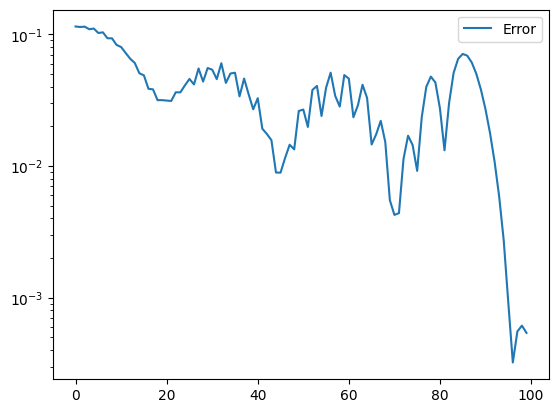

In [7]:
test_green_expandido(D, d, N, 175)

## 3. Analisis de frecuencia/términos usando mayor precisión

In [8]:
import mpmath as mp

mp.mp.dps = 100

In [9]:
def mp_sph_jn(n, z):
    """
    Evalua función esferica de Bessel de primer tipo de grado n en z
    """
    return mp.besselj(n + mp.mpf(1) / 2, z) / mp.sqrt(2 * z / mp.pi)

In [10]:
def mp_sph_yn(n, z):
    """
    Evalua función esferica de Bessel de segundo tipo de grado n en z
    """
    return mp.bessely(n + mp.mpf(1) / 2, z) / mp.sqrt(2 * z / mp.pi)

In [11]:
def mp_sph_hn1(n, z):
    """
    Evalua función esferica de Hankel de primer tipo de grado n en z
    """
    return mp_sph_jn(n, z) + 1j * mp_sph_yn(n, z)

In [12]:
def mp_green_expandido(D, d, N, k=1):
    """
    Modificación de green_expandido pero usando mpmath para mayor precisión
    """
    sums = mp.mpc(0)
    d_norm = mp.norm(d)
    D_norm = mp.norm(D)

    for l in range(N):
        sums += (
            (mp.mpf(-1)) ** mp.mpf(l)
            * (2 * mp.mpf(l) + mp.mpf(1))
            * mp_sph_jn(mp.mpf(l), k * d_norm)
            * mp_sph_hn1(mp.mpf(l), k * D_norm)
            * mp.legendre(mp.mpf(l), (d.T * D)[0] / (d_norm * D_norm))
        )

    return mp.mpc(1j) * k * sums

In [13]:
def mp_test_green_expandido(D, d, N, k):
    """
    Prueba la función mp_green_expandido
    """
    real = (mp.e ** (mp.mpc(1j) * mp.mpf(k) * mp.norm(D + d))) / mp.norm(D + d)
    aproximaciones = []
    errores = []
    for i in range(N):
        aprox = mp_green_expandido(D, d, i, k)
        aproximaciones.append(aprox)

        errores.append(mp.fabs(real - aprox))

    parte_real = [mp.re(x) for x in aproximaciones]
    parte_imaginaria = [mp.im(x) for x in aproximaciones]

    plt.plot(range(N), parte_real, label="Aproximación Parte Real")
    plt.plot(range(N), parte_imaginaria, label="Aproximación Parte Imaginaria")
    plt.legend()
    plt.show()

    plt.plot(range(N), errores, label="Error")
    plt.yscale("log")
    plt.legend()
    plt.show()

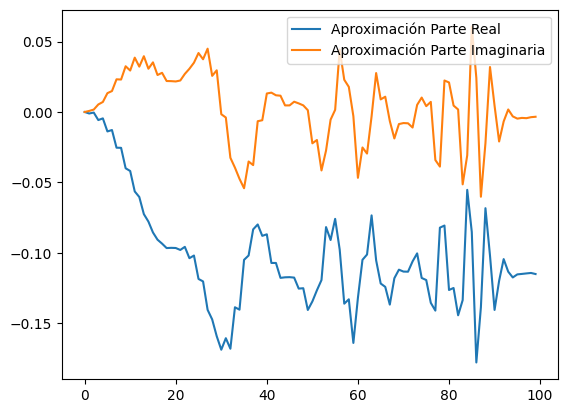

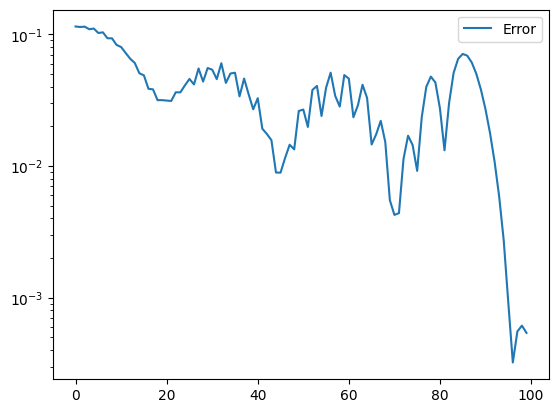

In [16]:
d = mp.matrix([0.5, 0, 0.1])
D = mp.matrix([8, 1, 1.5])
N = 100

mp_test_green_expandido(D, d, N, 175)

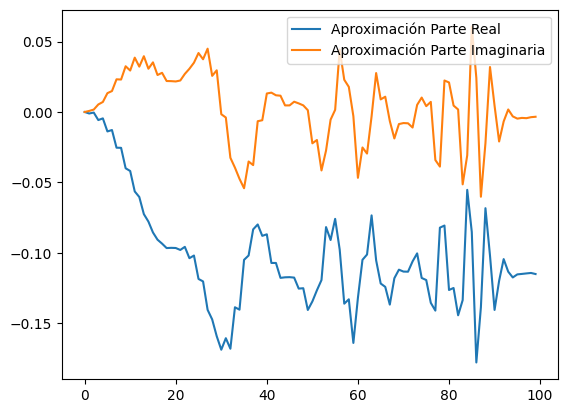

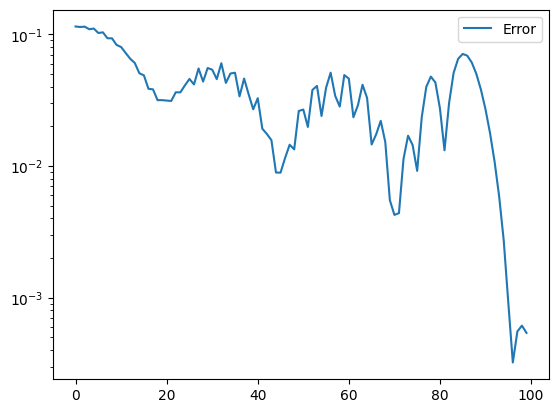

In [27]:
d = np.array([0.5, 0, 0.1])
D = np.array([8, 1, 1.5])
N = 100

test_green_expandido(D, d, N, 175)

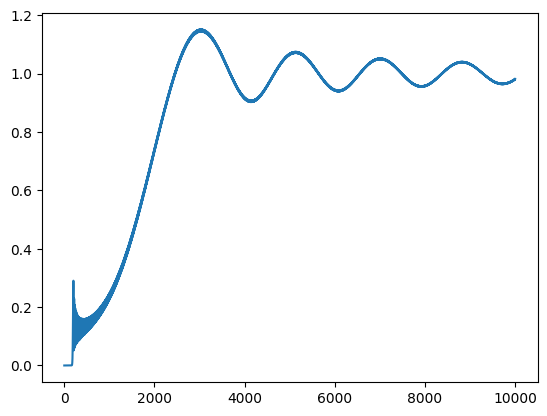

In [17]:
errores = []
frecuencia_max = 10000
for k in range(1, frecuencia_max):
    real = mp.e ** (mp.mpc(1j) * mp.mpf(k) * mp.norm(D + d)) / mp.norm(D + d)
    aprox = mp_green_expandido(D, d, 100, k)

    errores.append(mp.fabs(real - aprox) / mp.fabs(real))

plt.plot(range(1, frecuencia_max), errores, label="Error")

## Diferencias mpmath vs numpy/scipy

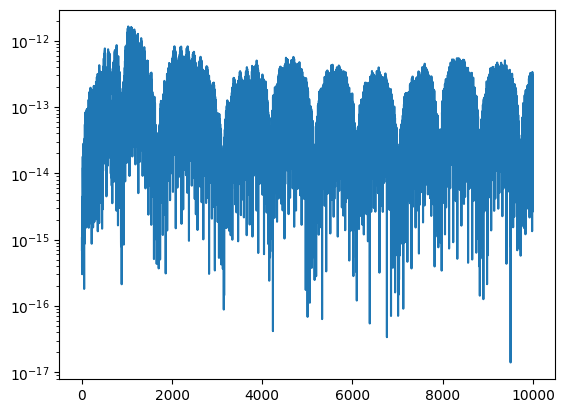

In [26]:
plt.plot(
    range(1, frecuencia_max),
    abs(np.array(errores2) - np.array(errores)),
    label="Diferencia",
)
plt.yscale("log")
plt.show()